In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/files/AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [5]:
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data

<ipython-input-5-155d57571535>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [6]:
# Prepare DataFrame for LSTM
lookback = 7
data.set_index('Date', inplace=True)
for i in range(1, lookback + 1):
    data[f'Close(t-{i})'] = data['Close'].shift(i)
data.dropna(inplace=True)
data

<ipython-input-6-d218986d4569>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Close(t-{i})'] = data['Close'].shift(i)
<ipython-input-6-d218986d4569>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Close(t-{i})'] = data['Close'].shift(i)
<ipython-input-6-d218986d4569>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [7]:
# Convert to PyTorch tensors
X = torch.FloatTensor(data.iloc[:, 1:].values) # x values are from column 1 to end
# the view function also adds an additional dimension
y = torch.FloatTensor(data.iloc[:, 0].values).view(-1, 1) # y values are in column 0

# Normalize data using scikit-learn MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X = torch.FloatTensor(scaler.fit_transform(X.numpy()))

print('Initial X shape ', X.shape)

# Reshape data for LSTM
# The view function in PyTorch is used to reshape a tensor. (-1: This is a placeholder that means The view function automatically calculates the size, lookback: This is the second dimension specified, indicating the number of time steps to consider in each sequence. 1: This is the third dimension specified, indicating that each time step has one feature.)
X = X.view(-1, lookback, 1) # we added one more dimension for LSTM. In RNN or LSTM networks,  the input needs to be in the form of (batch_size, sequence_length (lookback), num_features)

print('final X shape ', X.shape)
print('final Y shape ', X.shape)

Initial X shape  torch.Size([6509, 7])
final X shape  torch.Size([6509, 7, 1])
final Y shape  torch.Size([6509, 7, 1])


In [8]:
# Split data into train and test sets
split_index = int(len(X) * 0.95)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create PyTorch data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
for x, y in train_loader:
    print(f"One batch x shape: {x.shape}")
    print(f"One batch y shape: {y.shape}")
    break

One batch x shape: torch.Size([16, 7, 1])
One batch y shape: torch.Size([16, 1])


In [10]:
# Iterate through the train_loader
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1) # input_size(features) = 1 ; hidden_size (The number of neurons in the hidden state) = 4; num_layers (The number of LSTM layers stacked on top of each other ) = 1
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [12]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [13]:
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [15]:
learning_rate = 0.001
num_epochs = 200
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1797.402
Batch 200, Loss: 1780.902
Batch 300, Loss: 2015.070

Val Loss: 10955.591
***************************************************

Epoch: 2
Batch 100, Loss: 1891.448
Batch 200, Loss: 1665.111
Batch 300, Loss: 1938.615

Val Loss: 10622.325
***************************************************

Epoch: 3
Batch 100, Loss: 1549.025
Batch 200, Loss: 1964.709
Batch 300, Loss: 1830.489

Val Loss: 10292.069
***************************************************

Epoch: 4
Batch 100, Loss: 1784.803
Batch 200, Loss: 1630.566
Batch 300, Loss: 1823.718

Val Loss: 9971.499
***************************************************

Epoch: 5
Batch 100, Loss: 1635.230
Batch 200, Loss: 1615.416
Batch 300, Loss: 1735.402

Val Loss: 9658.632
***************************************************

Epoch: 6
Batch 100, Loss: 1563.649
Batch 200, Loss: 1801.590
Batch 300, Loss: 1491.629

Val Loss: 9356.120
***************************************************

Epoch: 7
Batch 100, Loss: 1537.116
Ba

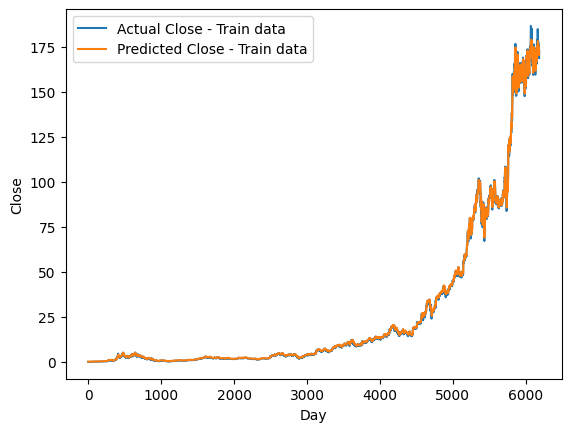

In [22]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close - Train data')
plt.plot(predicted, label='Predicted Close - Train data')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


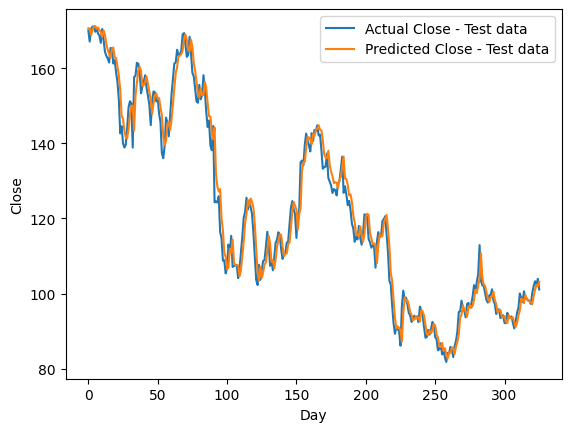

In [23]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual Close - Test data')
plt.plot(predicted, label='Predicted Close - Test data')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
